In [55]:
import hdbscan
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
import pandas as pd
from sentence_transformers import SentenceTransformer

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

### Load Preprocessed Data

In [7]:
articles = pd.read_parquet('../data/proc_articles.gzip')
articles = articles.reset_index(drop=True)

In [8]:
articles.head()

,title,author,publication,content,party
0,Breitbart Launches ’Border Wall Construction C...,Milo,Breitbart,Last weekend at church I confessed my sin of p...,right
1,IDF Airstrike Eliminates 4 Islamic State-Linke...,Breitbart Jerusalem,Breitbart,The Times of Israel reports: An Israeli airst...,right
2,Oracle Funds Anti-Google Effort that Outs Hill...,Chriss W. Street,Breitbart,The Oracle Corporation is using its deep finan...,right
3,Silicon Valley Urges Giving Election Day Off t...,Chriss W. Street,Breitbart,Apparently worried about the populist movement...,right
4,Illegal Migrant Abandoned in Desert Calls 911 ...,Bob Price,Breitbart,A severely dehydrated illegal alien called 911...,right


### Tokenize Articles

In [18]:
# Load in pre-trained DistilBERT model
# DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased , runs 60% faster while preserving over 95% of BERT's performances as measured on the GLUE language understanding benchmark
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [20]:
# Encode embeddings
embeddings = model.encode(articles['content'], show_progress_bar=True)

### Neighborhood-Based Dimensionality Reduction

In [36]:
# Perform non-linear dimensionality reduction
umap_embeddings = umap.UMAP(n_neighbors=30, n_components=5, min_dist=0.1, metric='cosine').fit_transform(embeddings)

### Density-Based Clustering

In [ ]:
# Perform density-based clustering on dimensionality reduced embeddings
cluster = hdbscan.HDBSCAN(min_cluster_size=300, metric='euclidean').fit(umap_embeddings)

In [48]:
# Frequencies of each cluster/label
unique, counts = np.unique(cluster.labels_, return_counts=True)
np.asarray((unique, counts)).T

### Plot Clusters

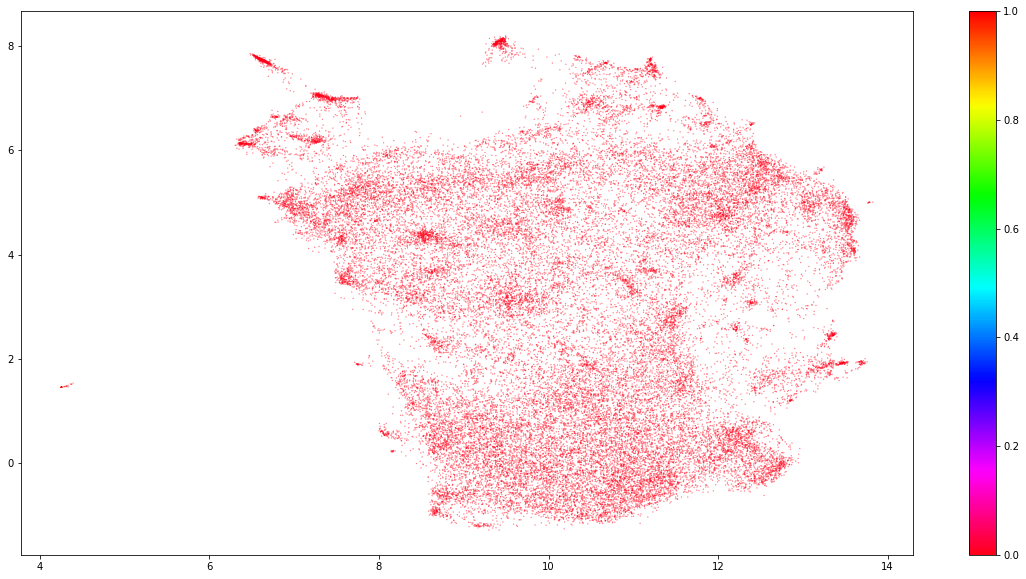

In [49]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.1, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=10, cmap='hsv_r')
plt.colorbar()

### Topic Modeling

In [54]:
# Assign articles to topics
docs_df = pd.DataFrame(articles['content'])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_df.columns = ['Doc', 'Topic', 'Doc_ID']
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
docs_per_topic.head()

{0, 1}

In [ ]:
# Compute c-TF-IDF scores for each word
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)
    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(articles['content']))

In [ ]:
# Extract top words for each topic
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

### Test Topics

In [ ]:
top_n_words[0][:10]

In [ ]:
top_n_words[5][:10]

In [ ]:
top_n_words[6][:10]